In [1]:
import numpy as np
from scipy import signal
import seaborn as sns
import scipy.stats as stats
from scipy.ndimage.interpolation import shift
import scipy.interpolate as interpolate
import itertools as it
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from lab.classes.dbclasses import dbMouse
from lab.analysis import behavior_analysis as ba
from lab.misc.auto_helpers import locate
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
%run Helper_Functions.ipynb

In [3]:
with open('Waveform_Corr_w_Ripple_Durations_2.pkl', 'rb') as f:
    data = pickle.load(f)

In [4]:
data = data[data.Region != 'CA1']
data = data.replace(to_replace = 'Bistr', value = 'SOM')
data = data.replace(to_replace = 'SOM/CB', value = 'SOM')
data = data.replace(to_replace = 'CA2/CA3', value = 'CA3')

/home/bert/.local/lib/python2.7/site-packages/pandas/core/missing.py:44: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


In [5]:
data = data[data.Region == 'CA3']
subtypes = ['PVBC', 'AAC', 'SOM', 'CCK', 'CB']
data = data[data.Subtype.isin(subtypes)]

In [ ]:
summary_data = [] 

for mousename in ['BV150', 'BV151', 'BV152', 'BV153', 'BV154', 'BV160', 'BV163', 'BV165', \
                  'BV167', 'BV169', 'TG531', 'TG532', 'TG535']:
    print mousename,
    exptListAll = [expt for expt in dbMouse(mousename).imagingExperiments() if \
                   (expt.experimentType == 'rippleActivity') or \
                    expt.experimentType == 'PreGOL' or expt.experimentType == 'PreSatiety']

    for rippleGrp in np.sort(np.unique((map(lambda x: x.rippleGrp, exptListAll)))):
        print rippleGrp,
        for roiID in np.sort(np.unique(data[data.mouse == mousename][data.grp == rippleGrp]\
                            .Imaging_Plane.values)):
            cell_data = data[data.mouse == mousename][data.grp == rippleGrp]\
                [data.Imaging_Plane == roiID]
            avg_high_dur_trace = cell_data.Avg_High_Dur_Trace.values[0]
            avg_low_dur_trace = cell_data.Avg_Low_Dur_Trace.values[0]
            n_high_dur_ripples = cell_data.n_high_dur_ripples.values[0] 
            n_low_dur_ripples = cell_data.n_low_dur_ripples.values[0]
            if (n_high_dur_ripples >= 0) & (n_low_dur_ripples >= 0):
                difference_curve = avg_high_dur_trace - avg_low_dur_trace
                difference_curve = resample_trace(difference_curve, 600)
                pre_mean_diff = np.nanmean(difference_curve[250:300])
                post_mean_diff = np.nanmean(difference_curve[300:350])
                
                summary_data.append({'Mouse': mousename,
                                'RippleGrp': rippleGrp,
                                'roiID': roiID,
                                'Subtype': cell_data.Subtype.values[0],
                                'Pre_Mean_Diff': pre_mean_diff,
                                'Post_Mean_Diff': post_mean_diff})
            
summary_data = pd.DataFrame(summary_data)

count = 0
for mousename in ['BV150', 'BV151', 'BV152', 'BV153', 'BV154', 'BV160', 'BV163', 'BV165', \
                  'BV167', 'BV169', 'TG531', 'TG532', 'TG535']:
    print mousename,
    exptListAll = [expt for expt in dbMouse(mousename).imagingExperiments() if \
                   (expt.experimentType == 'rippleActivity') or \
                    expt.experimentType == 'PreGOL' or expt.experimentType == 'PreSatiety']
    for rippleGrp in np.sort(np.unique((map(lambda x: x.rippleGrp, exptListAll)))):
        print rippleGrp,
        for roiID in np.sort(np.unique(data[data.mouse == mousename][data.grp == rippleGrp]\
                            .Imaging_Plane.values)):
            summary_data.loc[(summary_data.Mouse == mousename) & \
                    (summary_data.RippleGrp == rippleGrp) & \
                    (summary_data.roiID == roiID), 'Count'] = int(count)
            count = count + 1

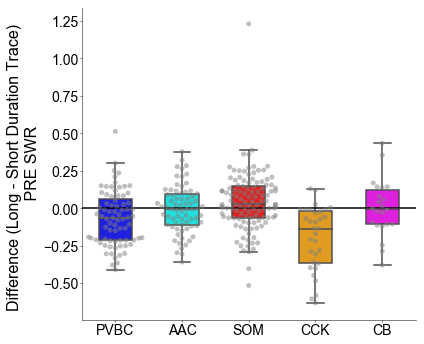

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (6,5))
my_palette = ['blue', 'cyan', 'red', 'orange', 'magenta']
sns.swarmplot(x = 'Subtype', y = 'Pre_Mean_Diff', data = summary_data, order = order, \
              alpha = 0.5, color = 'gray')
sns.boxplot(x = 'Subtype', y = 'Pre_Mean_Diff', data = summary_data, order = order, \
            boxprops = dict(alpha = 1.0), palette = my_palette, width = 0.5, \
            showfliers = False)
ax.tick_params(axis = 'x', labelsize = 14)
ax.tick_params(axis = 'y', labelsize = 14)
ax.axhline(y = 0, color = 'black')
ax.set_xlabel('')
ax.set_ylabel('Difference (Long - Short Duration Trace) \n PRE SWR', fontsize = 16)
#ax.set_xticklabels([])
#ax.set_yticklabels([])
simpleaxis(ax)

fig.tight_layout()
plt.savefig('Long_Minus_Short_Duration_PRE_Single_Cell_Quantification.svg', \
            format = 'svg', dpi = 1200, transparent = True)

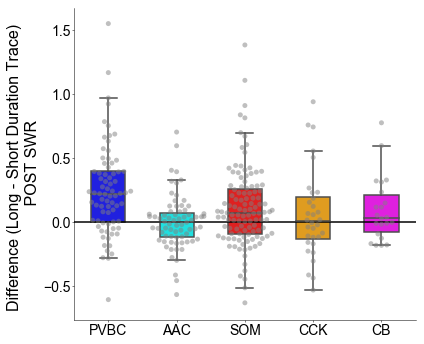

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (6, 5))
my_palette = ['blue', 'cyan', 'red', 'orange', 'magenta']
sns.swarmplot(x = 'Subtype', y = 'Post_Mean_Diff', data = summary_data, order = order, \
              alpha = 0.5, color = 'gray')
sns.boxplot(x = 'Subtype', y = 'Post_Mean_Diff', data = summary_data, order = order, \
            boxprops = dict(alpha = 1.0), palette = my_palette, width = 0.5, \
            showfliers = False)
ax.tick_params(axis = 'x', labelsize = 14)
ax.tick_params(axis = 'y', labelsize = 14)
ax.axhline(y = 0, color = 'black')
ax.set_xlabel('')
ax.set_ylabel('Difference (Long - Short Duration Trace) \n POST SWR', fontsize = 16)
#ax.set_xticklabels([])
#ax.set_yticklabels([])
simpleaxis(ax)

fig.tight_layout()
plt.savefig('Long_Minus_Short_Duration_POST_Single_Cell_Quantification.svg', \
            format = 'svg', dpi = 1200, transparent = True)

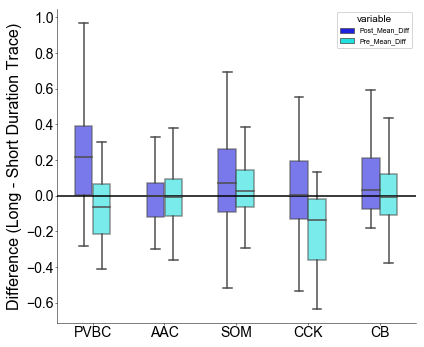

In [53]:
fig, ax = plt.subplots(1, 1, figsize = (6,5))
my_palette = ['blue', 'cyan', 'red', 'orange', 'magenta']
#sns.swarmplot(x = 'Subtype', y = 'value', hue = 'variable', data = compressed_data, \
#              order = order, alpha = 0.5, color = 'gray')
sns.boxplot(x = 'Subtype', y = 'value', hue = 'variable', data = compressed_data, \
            order = order, boxprops = dict(alpha = 0.6), palette = my_palette, \
            width = 0.5, showfliers = False)
ax.tick_params(axis = 'x', labelsize = 14)
ax.tick_params(axis = 'y', labelsize = 14)
ax.axhline(y = 0, color = 'black')
ax.set_xlabel('')
ax.set_ylabel('Difference (Long - Short Duration Trace)', fontsize = 16)
#ax.set_xticklabels([])
#ax.set_yticklabels([])
simpleaxis(ax)

fig.tight_layout()
plt.savefig('Long_Minus_Short_Duration_Single_Cell_Quantification.svg', \
            format = 'svg', dpi = 1200, transparent = True)